In [1]:
from IPython.core.interactiveshell import InteractiveShell
from matplotlib import font_manager
import matplotlib.style as style
import argparse
import logging
import os
import sys
import pysam
import pandas as pd
from collections import defaultdict
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
from collections import defaultdict
from scipy import stats
import glob
logger = logging.getLogger("duplex yield logger")
from itertools import product
import pybedtools
#print(pybedtools.__version__)
get_ipython().events.trigger('post_run_cell')
%matplotlib inline
style.use('seaborn-ticks')
InteractiveShell.ast_node_interactivity = 'all'
pd.options.display.max_rows = 100
pd.set_option("max_colwidth", 400)

In [2]:
def prepare(dest, group = None):
    duplex_yield = []
    for file in glob.glob(dest):
        base = os.path.basename(file)
        sample = base.replace('.duplex_yield_metrics.txt', '')
        sample_split = sample.split('_')
        print(file)
        duplex_yield_df = pd.read_table(file)
        duplex_yield_df['sample_id'] = sample_split[1]
        panel = sample_split[1] + '_' + sample_split[2]
        duplex_yield_df['PANEL'] = panel
        duplex_yield_df['GROUP'] = group
        duplex_yield_df = duplex_yield_df.sort_values(by='read_pairs')
        duplex_yield_df['ds_duplexes_mavg']= duplex_yield_df.ds_duplexes.rolling(300).mean().shift(-150)
        a = duplex_yield_df.target.str.split(':', expand=True)
        b = a.iloc[:,1].str.split('-', expand=True)
        duplex_yield_df['start'] = b.iloc[:,0].astype(int)
        duplex_yield_df['end'] = b.iloc[:,1].astype(int)
        duplex_yield.append(duplex_yield_df)
    duplex_saturation_df = pd.concat(duplex_yield, ignore_index = True)
    return duplex_saturation_df

In [3]:
def read_pair_generator(bam, chrom = None, start = 0, end = 0):
    """
    Generate read pairs in a BAM file or within a region string.
    Reads are added to read_dict until a pair is found.
    """
    read_dict = defaultdict(lambda: [None, None])
    for read in bam.fetch(chrom, start, end) if chrom else bam.fetch(until_eof=True):
        if read.is_secondary or read.is_supplementary:
            continue
        qname = read.query_name
        if qname not in read_dict:
            if read.is_read1:
                read_dict[qname][0] = read
            else:
                read_dict[qname][1] = read
        else:
            if read.is_read1:
                yield read, read_dict[qname][1]
            else:
                yield read_dict[qname][0], read
            del read_dict[qname]
def read_bed(bedfile):
    """ Creates generator from bed file or interval_list """
    logger.info("Reading region file...")
    interval_list = bedfile.endswith("interval_list")
    with open(bedfile, "r") as bed:
        for line in bed:
            if line.startswith("@"):
                continue
            line = line.strip()
            chrom, start, stop = line.split()[0:3]
            start, stop = int(start), int(stop)
            if interval_list:
                start -= 1
            yield chrom, start, stop
def is_overlapped(read1, read2):
    if read1.is_unmapped or read2.is_unmapped:
        return False
    if read1.reference_name != read2.reference_name:
        return False
    if read1.reference_start < read2.reference_end and read2.reference_start < read1.reference_end:
        return True
def overlap_len(read1, read2):
    if not is_overlapped(read1,read2):
        return 0
    else:
        return min(read1.reference_end, read2.reference_end) - max(read1.reference_start, read2.reference_start)

In [3]:
def duplex_yield(duplex_metrics_dir, metadata):
    metadata = metadata.drop_duplicates(['sample'])
    alldf = pd.DataFrame()
    for row in metadata.itertuples():
        sm = row.sample
        fpfile = os.path.join(duplex_metrics_dir, sm+".duplex_yield_metrics.txt")
        #results.loc[slid, 'sample_type'] = stype
        df = pd.read_table(fpfile)
        df['sample_id'] = sm
        alldf = pd.concat([alldf, df])
        #print(df)
        #results.loc[slid, 'raw_reads'] = df[df['fraction']==1]["read_pairs"].sum() # sum is just converting series to float
        #results.loc[slid, 'duplexes'] = df[df['fraction']==1]['ds_duplexes'].sum()
    return alldf

In [9]:
####General saturation plot
def saturation_plot(duplex_saturation_df, yvalue='ds_duplexes', colorby='GROUP', style='sample'):
#     g = sns.FacetGrid(duplex_saturation_df, col='GROUP', height=5)
#     g.map_dataframe(sns.lineplot, x = 'read_pairs', y = yvalue, units = 'target', hue = colorby, alpha=0.5,
#                       linewidth = 2.5,
#                       #estimator = np.median,  err_style='band', ci=None,
#                       estimator = None)
    fig = plt.figure(figsize = (18, 12))
    ax = fig.add_subplot(111)

    lp = sns.lineplot(x = 'read_pairs', y = 'ds_duplexes_mavg', hue = colorby, ci=None,
                      linewidth = 4, style = style,ax=ax,
                      units='sample_id',
                      #err_style='band', 
                    dashes = [[1,0], [1,4]],
                     estimator = None, data = duplex_saturation_df, legend="full")


    _ = ax.set_xlabel('Read Pairs', fontsize=28)
    _ = ax.set_ylabel('Unique duplex depth per target', fontsize=28)
    _ = ax.set_xscale('log')
    _ = ax.set_yscale('log')
    _ = ax.set_ylim(1,10000)
    _ = ax.legend(frameon = True)
    _ = ax.spines['top'].set_visible(False)
    _ = ax.spines['right'].set_visible(False)
    _ = ax.tick_params(axis='both', labelsize=28)
    _ = ax.tick_params(axis='both', labelsize=28)
    
    fig.tight_layout()
    plt.legend(loc=2, prop={'size': 20})
    plt.savefig('various_dna_input_vs_duplex_yeild.pdf')

In [ ]:
metdir = "/xchip/bloodbiopsy/ruolin/link_duplex/paper/data/figure2/c/codec"
pattern="cfDNA"
yeild_files = [file for file in os.listdir(metdir) if "duplex_yield_metrics" in file]
yeild_files = [file for file in yeild_files if pattern in file]
snames = [s.split('.')[0] for s in yeild_files]
codec_total_df = pd.DataFrame()
for sn, f in zip(snames, yeild_files):
    df = prepare(os.path.join(metdir, f), sn)
    codec_total_df = pd.concat([codec_total_df, df])
codec_total_df = codec_total_df.reset_index()
codec_total_df['GROUP']="CODEC"

In [ ]:
dupseqdir="/xchip/bloodbiopsy/ruolin/link_duplex/paper/data/figure2/c/dupseq"
pattern="cfDNA"
yeild_files = [file for file in os.listdir(dupseqdir) if "duplex_yield_metrics" in file]
yeild_files = [file for file in yeild_files if pattern in file]
snames = [s.split('.')[0] for s in yeild_files]
dupseq_total_df = pd.DataFrame()
for sn, f in zip(snames, yeild_files):
    df = prepare(os.path.join(dupseqdir, f), sn)
    dupseq_total_df = pd.concat([dupseq_total_df, df])
dupseq_total_df = dupseq_total_df.reset_index()
dupseq_total_df['GROUP']="DupSeq"

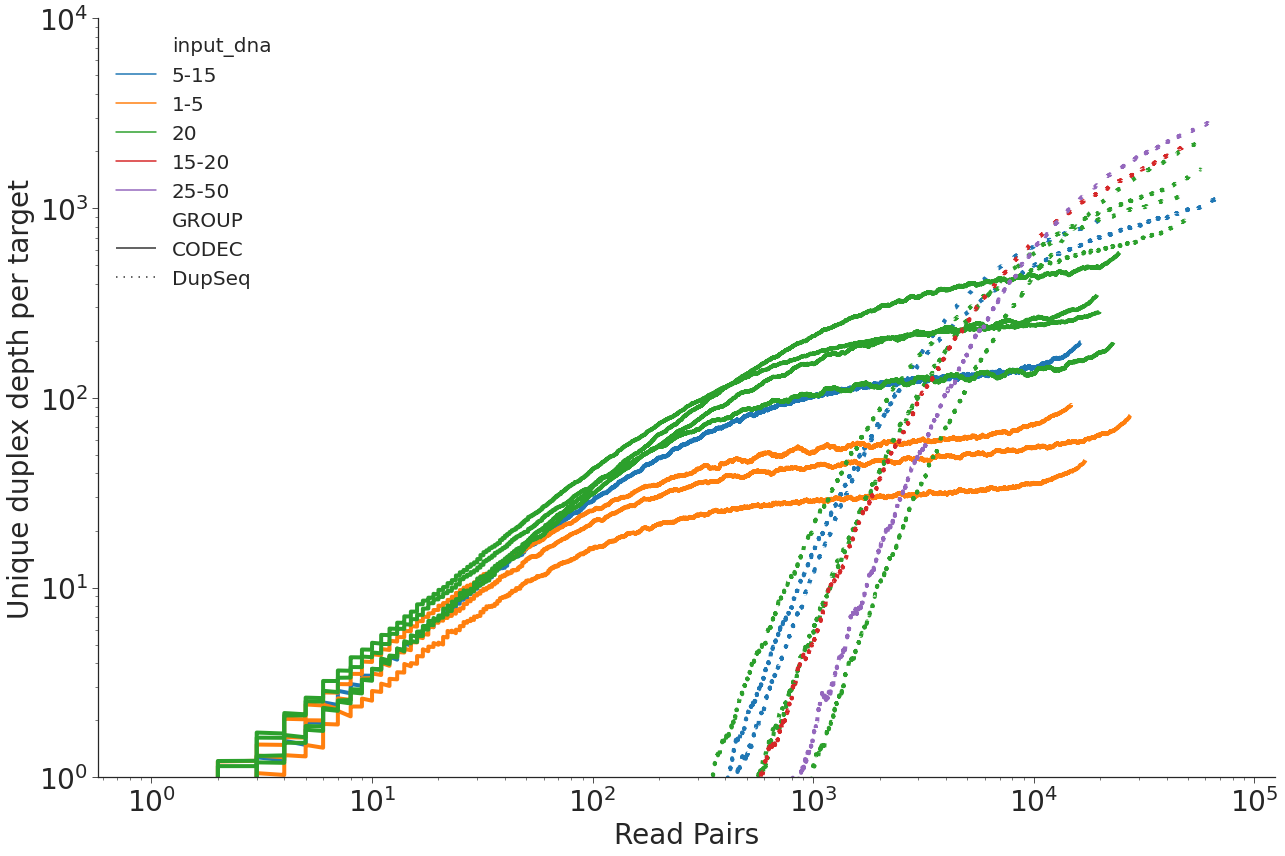

In [10]:
codec_input = {'159391':'1-5', '147579':'1-5', '173793':'1-5', '192824':'5-15', 
               '123':'20', '126':'20', '127':'20', '130':'20'}
codec_total_df['input_dna'] = codec_total_df['sample_id'].map(lambda x : codec_input[x])

dupseq_input = {'159391':'5-15', '147579':'5-15', '173793':'15-20', '192824':'25-50', 
               '123':'20', '126':'20', '127':'20', '130':'20'}
dupseq_total_df['input_dna'] = dupseq_total_df['sample_id'].map(lambda x : dupseq_input[x])

total_df = pd.concat([codec_total_df, dupseq_total_df])
total_df = total_df.reset_index()


saturation_plot(total_df, colorby="input_dna", style="GROUP")

# Fig 4i, Mutant duplex recovery

In [15]:
metdir = "/xchip/bloodbiopsy/ruolin/link_duplex/paper/data/figure4/i/codec"
yeild_files = [file for file in os.listdir(metdir) if "cfDNA.duplex_yield_metrics" in file]
snames = [s.split('.')[0] for s in yeild_files]
print(snames)
codec_total_df = pd.DataFrame()
for sn, f in zip(snames, yeild_files):
    df = pd.read_csv(os.path.join(metdir, f), sep='\t')
    df['sample']=sn
    codec_total_df = pd.concat([codec_total_df, df])
codec_total_df = codec_total_df.reset_index()
codec_total_df['GROUP']="CODEC"
codec_total_df.head()

['BC147579_dc_cfDNA', 'BC192824_dc_cfDNA', 'BC173793_dc_cfDNA', 'BC159391_dc_cfDNA']


,index,fraction,read_pairs,cs_families,ss_families,ds_families,ds_duplexes,ds_fraction_duplexes,sample,GROUP
0,0,1.000000,27508821,13978268,16364062,13148938,208,0.000016,BC147579_dc_cfDNA,CODEC
1,1,0.727895,20022624,10631689,12481340,10042415,205,0.000020,BC147579_dc_cfDNA,CODEC
2,2,0.529832,14572627,8024838,9445286,7605919,203,0.000027,BC147579_dc_cfDNA,CODEC
3,3,0.385662,10608446,6025326,7107337,5726438,200,0.000035,BC147579_dc_cfDNA,CODEC
4,4,0.280722,7721827,4505552,5327265,4292227,196,0.000046,BC147579_dc_cfDNA,CODEC


In [16]:
metdir = "/xchip/bloodbiopsy/ruolin/link_duplex/paper/data/figure4/i/dupseq"
yeild_files = [file for file in os.listdir(metdir) if "cfDNA.duplex_yield_metrics" in file]
snames = [s.split('.')[0] for s in yeild_files]
print(snames)
dupseq_total_df = pd.DataFrame()
for sn, f in zip(snames, yeild_files):
    df = pd.read_csv(os.path.join(metdir, f), sep='\t')
    df['sample']=sn
    dupseq_total_df = pd.concat([dupseq_total_df, df])
dupseq_total_df = dupseq_total_df.reset_index()
dupseq_total_df['GROUP']="DupSeq"
dupseq_total_df.head()

['BC147579_dc_cfDNA', 'BC192824_dc_cfDNA', 'BC173793_dc_cfDNA', 'BC159391_dc_cfDNA']


,index,fraction,read_pairs,cs_families,ss_families,ds_families,ds_duplexes,ds_fraction_duplexes,sample,GROUP
0,0,1.000000,18421322,1342032,2469821,1519055,353,0.000232,BC147579_dc_cfDNA,DupSeq
1,1,0.727895,13408309,1284269,2354446,1459631,316,0.000216,BC147579_dc_cfDNA,DupSeq
2,2,0.529832,9759266,1223609,2220190,1395327,250,0.000179,BC147579_dc_cfDNA,DupSeq
3,3,0.385662,7102638,1157450,2061758,1323299,176,0.000133,BC147579_dc_cfDNA,DupSeq
4,4,0.280722,5170615,1083961,1876284,1240856,113,0.000091,BC147579_dc_cfDNA,DupSeq


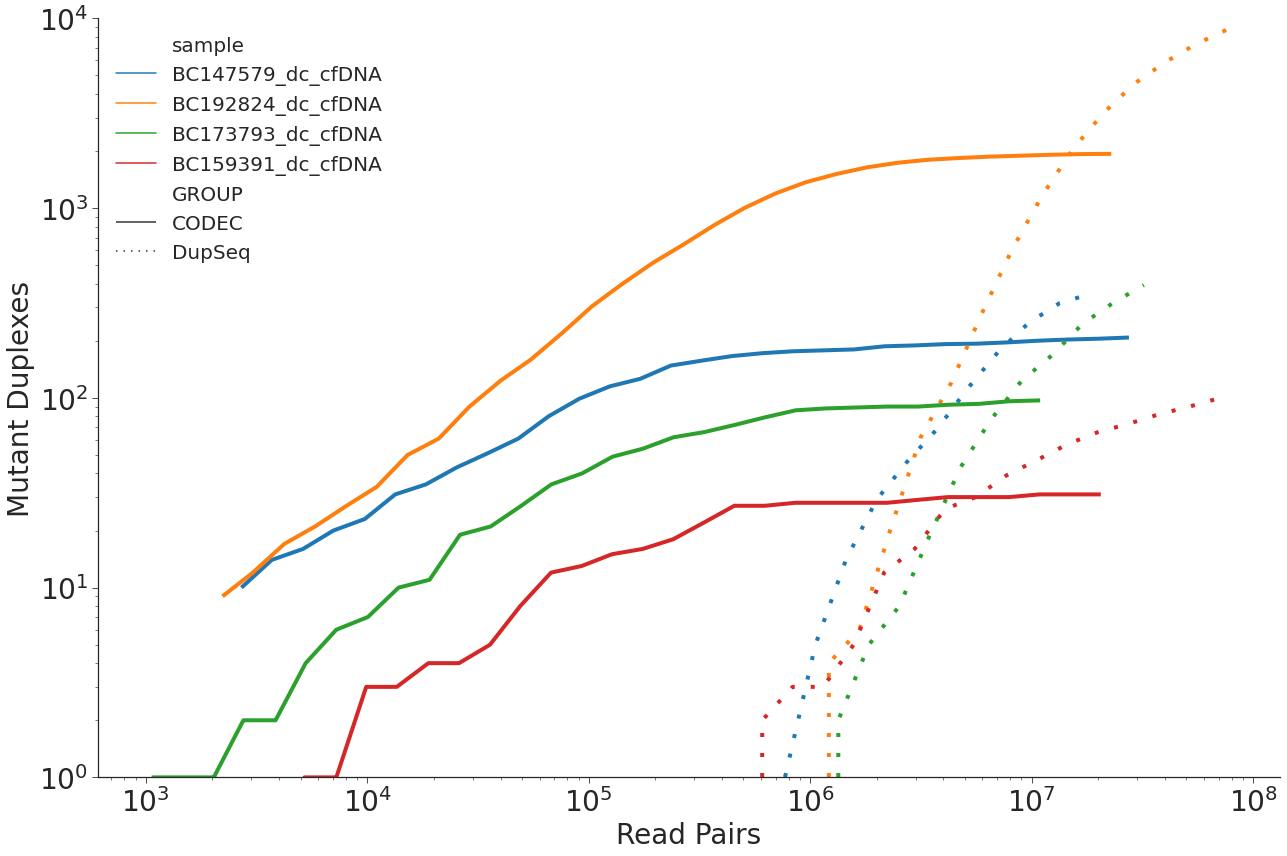

In [17]:
def saturation_plot(duplex_saturation_df, yvalue='ds_duplexes', colorby='GROUP', style='sample'):
#     g = sns.FacetGrid(duplex_saturation_df, col='GROUP', height=5)
#     g.map_dataframe(sns.lineplot, x = 'read_pairs', y = yvalue, units = 'target', hue = colorby, alpha=0.5,
#                       linewidth = 2.5,
#                       #estimator = np.median,  err_style='band', ci=None,
#                       estimator = None)
    fig = plt.figure(figsize = (18, 12))
    ax = fig.add_subplot(111)

    lp = sns.lineplot(x = 'read_pairs', y = 'ds_duplexes', hue = colorby, ci=None,
                      linewidth = 4, style = style,ax=ax, 
                      units='sample',
                      #err_style='band', 
                     dashes = [[1,0], [1,4]],
                     estimator = None, data = duplex_saturation_df, legend="full")


    _ = ax.set_xlabel('Read Pairs', fontsize=28)
    _ = ax.set_ylabel('Mutant Duplexes', fontsize=28)
    _ = ax.set_xscale('log')
    _ = ax.set_yscale('log')
    _ = ax.set_ylim(1,10000)
    #_ = ax.set_xlim(1, 10_000_000)
    _ = ax.legend(frameon = True)
    _ = ax.spines['top'].set_visible(False)
    _ = ax.spines['right'].set_visible(False)
    _ = ax.tick_params(axis='both', labelsize=28)
    _ = ax.tick_params(axis='both', labelsize=28)
    
    fig.tight_layout()
    plt.legend(loc=2, prop={'size': 20})
    #plt.savefig('mutant_duplex_vs_readpairs.pdf')
totdf = pd.concat([codec_total_df, dupseq_total_df])
totdf = totdf.reset_index()
saturation_plot(totdf, colorby="sample", style="GROUP")